## Import Packages

In [97]:
import os
import glob
import numpy as np
import pandas as pd
#import network_fcon as fc
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

### Set Variables and Paths

In [95]:
# Set paths
path = "/Users/pecsok/Desktop/ImageData/PMACS_remote"
path = "/Users/pecsok/Desktop/ImageData/PMACS_remote/analyses/S1000"

# Import group dataframes and set indices
#subjlist = pd.read_csv(path + "data/pipeline_input_all_subj.csv", sep=',') 
cestmat = pd.read_csv("cest_parcelmat" + fieldstrength + ".csv", sep=',') 
fcmat = pd.read_csv("fc_parcelmat_" + fieldstrength + ".csv", sep=',')
rehomat = pd.read_csv("reho_parcelmat" + fieldstrength + ".csv", sep=',')
grp_df = pd.read_csv("filtered_grp_df" + fieldstrength + ".csv", sep=',')

# Reformat some dfs
cestmat.set_index('BBLID', inplace = True)
fcmat.set_index('BBLID', inplace = True)
rehomat.set_index('BBLID', inplace = True)
grp_df.set_index('BBLID', inplace = True)
subjlist = subjlist.dropna(how='all')
subjlist.rename(columns={'fMRI Field Strength': 'fieldstrength'},inplace=True)
# Correct subject list for future! 
subjlist.loc[subjlist['BBLID'] == 88608.0, 'SCANID_rs'] = 'motive2'
subjlist.loc[subjlist['BBLID'] == 20792.0, 'SCANID_rs'] = 'motive2'
subjlist.loc[subjlist['BBLID'] == 88760.0, 'SCANID_rs'] = 'motive2'
subjlist.loc[subjlist['BBLID'] == 112126.0, 'SCANID_rs'] = 'motive1'
subjlist.loc[subjlist['BBLID'] == 91962.0, 'SCANID_rs'] = 'motive1'
subjlist.loc[subjlist['BBLID'] == 89279.0, 'SCANID_rs'] = 'motive1'
subjlist.loc[subjlist['BBLID'] == 91422.0, 'SCANID_rs'] = 'motive1'
subjlist.loc[subjlist['BBLID'] == 121407.0, 'SCANID_rs'] = '9257' 

# Set Variables
fieldstrength = '7T'
bblids = []
sesids = []
nmaps = ["mGluR5", "NMDA","GABA"]
diag_scores = ["dx_pscat", "hstatus","sex", "age", "race","ethnic"] # ,"axis1_desc1","axis1_stat1"
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
subjlist = subjlist[subjlist['fieldstrength'] == fieldstrength]
subjs = subjlist['BBLID']


### Create functions

In [72]:
def filter(df, filter_list):
    filtered_columns = [col for col in df.columns if not any(substring in col for substring in filter_list)]
    return df[filtered_columns]

def keep(df, keep_list):
    keep_columns = [col for col in df.columns if any(substring in col for substring in keep_list)]
    return df[keep_columns]   

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            valid_data = df[[col,col2]].dropna()
            if not valid_data.empty:
                _ , p = pearsonr(valid_data[col],valid_data[col2])
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
            else:
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = np.nan
    return p_matrix

### Create correlation matrix and heatmap

In [41]:
# Filter df to exclude subj info
subj_info = ["BBLID"] + ["Session"] + diag_scores + ["count"]
heat_df = filter(grp_df, subj_info)
print(heat_df)

        Unnamed: 0  NZMean_502  NZMean_504  NZMean_518  NZMean_521  \
BBLID                                                                
116019           0    9.713853    8.291109    9.405823   10.119331   
106057           1    8.935512    7.091272   11.613101    9.912003   
89095            2   11.382071   11.667863   13.527266   12.183442   
116019           3    9.713853    8.291109    9.405823   10.119331   
106057           4    8.935512    7.091272   11.613101    9.912003   
89095            5   11.382071   11.667863   13.527266   12.183442   
97994            6    6.372075    9.387987    5.636471    6.934195   
19981            7   13.532873    9.881411   14.269266    9.424947   
96659            8         NaN         NaN         NaN         NaN   
90281            9         NaN         NaN         NaN         NaN   
20180           10    8.807791    9.204619    9.693210    9.997270   
92211           11    9.917148   10.128813   11.441338   10.742408   
90077           12  

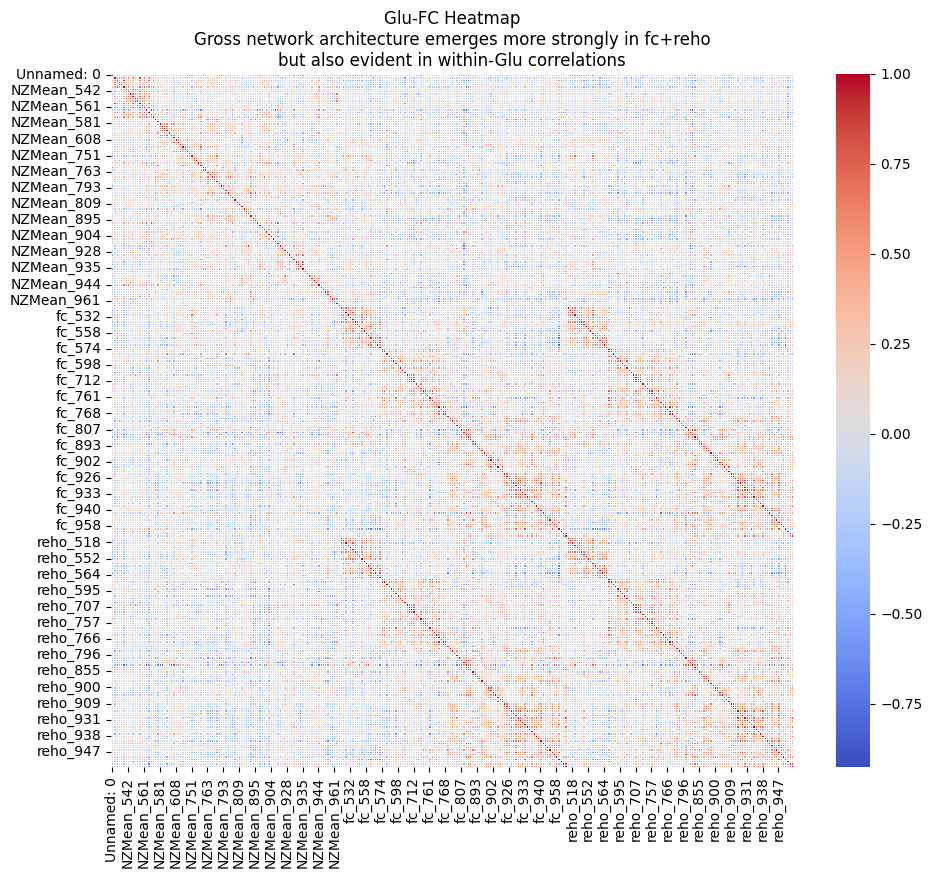

In [42]:
# Correlation matrix
corr_df=heat_df.corr()
plt.figure(figsize=(11,9))
sns.heatmap(corr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nGross network architecture emerges more strongly in fc+reho\nbut also evident in within-Glu correlations')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

### Correlation matrix after masking out the significant ones

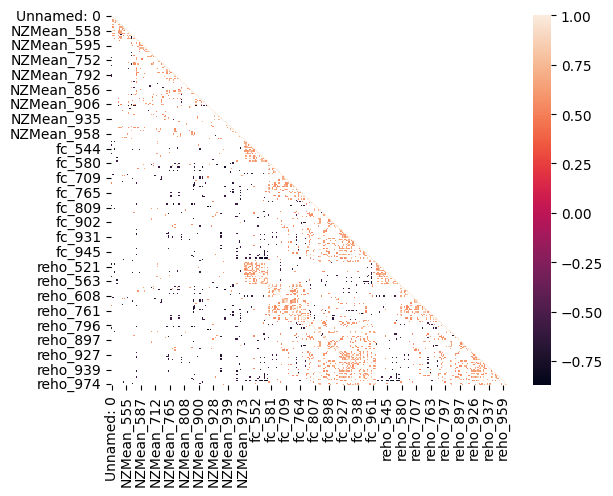

In [61]:
pvals = corr_sig(heat_df)
mask01 = np.invert(np.tril(pvals<0.01))
#mask001 = np.invert(np.tril(pvals<0.001))

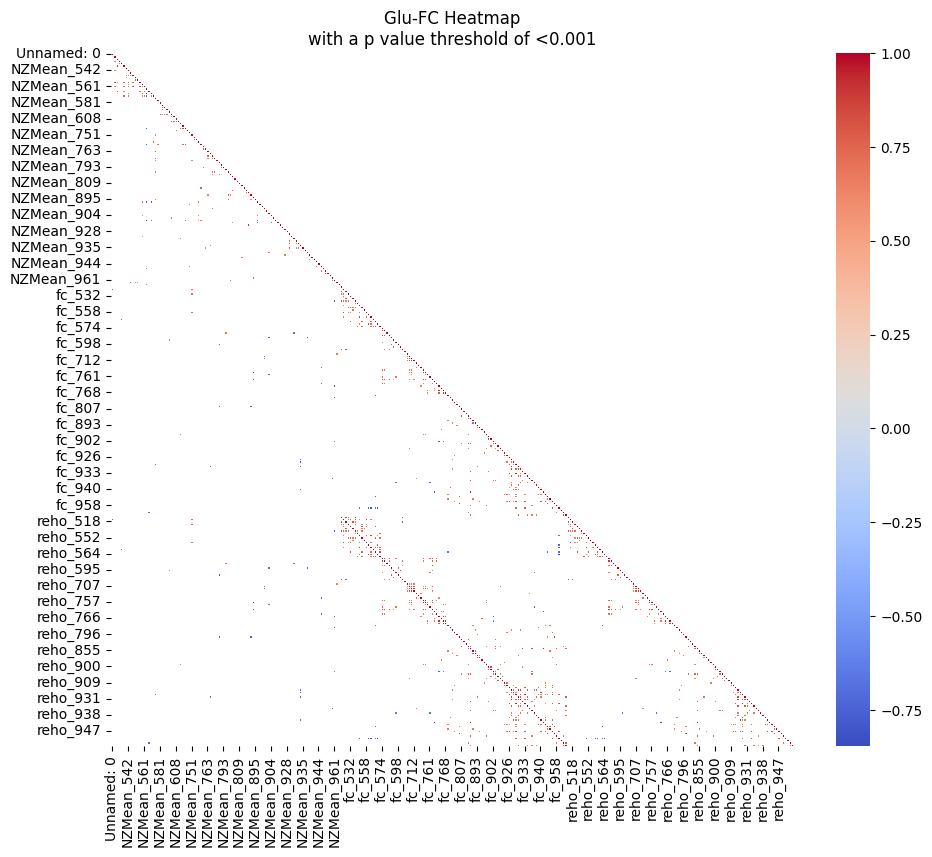

In [59]:
plt.figure(figsize=(11,9))
sns.heatmap(corr_df, mask=mask01, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-FC Heatmap\nwith a p value threshold of <0.001')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

### NMAP correlations

In [94]:
# Read in nmap data 
nmapsdf = pd.read_csv("receptor_data_scale1000_17.csv", sep=',', header=None)
nmapsdf.columns = nmaps 

# Trim cestmat and keep only the columns with avg values.
cestNZMeans = keep(grp_df, ["NZMean"])
#print(cestNZMeans)
cestavgs = cestNZMeans.mean(axis=0)
# Make new df to store avg nmap values and average CEST values.
glunmaps = nmapsdf.copy()
glunmaps.index = range(1,1001)
glunmaps["CESTavg"] = np.nan
# Add values to new df
for i in range(501,1001):
    cestparcel = f'NZMean_{i}'
    if cestparcel in cestavgs.index:
        #print(cestparcel)
        #print(cestavgs[cestparcel])
        glunmaps.loc[i,"CESTavg"] = cestavgs[cestparcel]
glunmaps = glunmaps.dropna(subset=["CESTavg"])
print(glunmaps)

       mGluR5      NMDA      GABA    CESTavg
502  7.192964 -0.377612  2.481264   9.747354
504  6.406018 -0.633749  1.279621  10.136727
518  5.827461 -1.884991 -0.392477  11.081808
521  6.869866 -0.751941  2.199508   9.913448
532  5.646722 -0.540665  0.404331   9.521379
540  7.195694  0.040774  3.016303   9.501262
542  7.618946 -0.190620  2.828990   9.712887
544  7.424842 -0.072134  2.550402   9.082923
545  7.679216  0.452993  2.681685   9.454588
552  6.987411 -0.947053  1.594165   9.046528
555  7.194250 -0.578195  0.658134   7.533093
558  7.182133  0.125620  2.474631   9.423410
560  7.148766  1.201754  2.612177   8.446940
561  7.233956  0.187993  1.134932   8.562086
562  7.172209  0.300837  1.613450   9.787545
563  4.545387 -0.732697 -0.808888   9.247213
564  6.983315  0.649158  1.166549   8.151183
567  4.278163 -0.983349 -1.137963   7.998704
574  6.804858  0.343051 -0.189310   8.523362
580  6.771057  0.244366 -0.213929   8.179645
581  6.826502  0.772918 -0.351751   7.478019
587  6.056

0.2207400037173778 0.027317771767749084
-0.043733604259764886 0.665709101832554
0.5266451339923073 1.821175272751789e-08


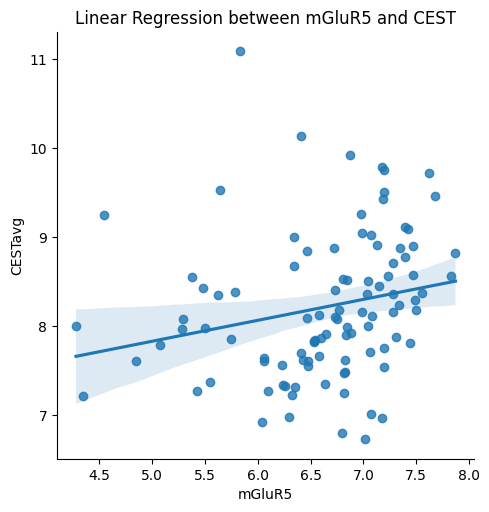

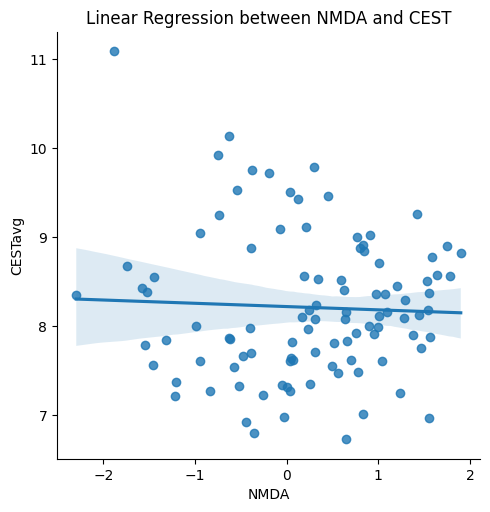

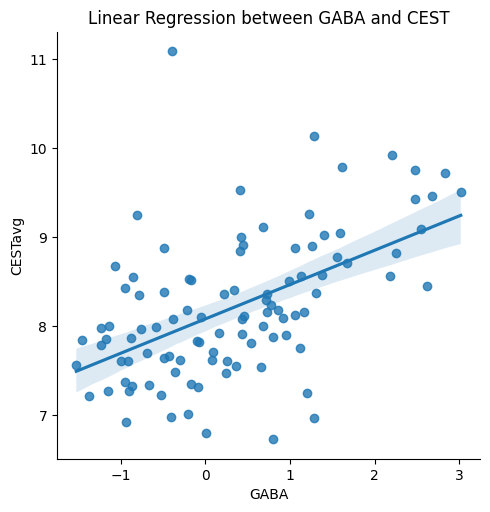

In [104]:
# Loop through nmaps and make correlation plots
for nmap in nmaps:
    formula = f'CESTavg ~ {nmap}'
    #model = smf.ols(formula=formula, data=glunmaps).fit()
    rval, pval = pearsonr(glunmaps[nmap],glunmaps["CESTavg"])
    print(rval,pval)
    #print(model.summary())


for nmap in nmaps:
    plot = sns.lmplot(x=nmap, y='CESTavg', data=glunmaps)
    plt.xlabel(nmap)
    plt.ylabel("CESTavg")
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['dx_pscat'] == 'PSY', network], graph_df.loc[graph_df['dx_pscat'] == 'PSY', cestcol])
    #plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for subset 2
    #slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    #plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    
    plt.title('Linear Regression between ' + nmap + ' and CEST')
    plt.show() 
